In [1]:
from time import process_time
import numpy as np
import matplotlib.pyplot as plt
from HARK.utilities import plotFuncs
from HARK.distribution import DiscreteDistribution
from HARK.ConsumptionSaving.ConsAggShockModel import (
    AggShockConsumerType,
    CobbDouglasEconomy,
    AggShockMarkovConsumerType,
    CobbDouglasMarkovEconomy,
)
from copy import deepcopy
def mystr(number):
    return "{:.4f}".format(number)

In [2]:
# Solve an AggShockConsumerType's microeconomic problem
solve_agg_shocks_micro = False
# Solve for the equilibrium aggregate saving rule in a CobbDouglasEconomy
solve_agg_shocks_market = True
# Solve an AggShockMarkovConsumerType's microeconomic problem
solve_markov_micro = False
# Solve for the equilibrium aggregate saving rule in a CobbDouglasMarkovEconomy
solve_markov_market = False
# Solve a simple Krusell-Smith-style two state, two shock model
solve_krusell_smith = True
# Solve a CobbDouglasEconomy with many states, potentially utilizing the "state jumper"
solve_poly_state = False

### Example implementation of AggShockConsumerType

In [3]:
if solve_agg_shocks_micro or solve_agg_shocks_market:
    # Make an aggregate shocks consumer type
    AggShockExample = AggShockConsumerType()
    AggShockExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    EconomyExample = CobbDouglasEconomy(agents=[AggShockExample])
    EconomyExample.makeAggShkHist()  # Simulate a history of aggregate shocks

    # Have the consumers inherit relevant objects from the economy
    AggShockExample.getEconomyData(EconomyExample)

In [4]:
if solve_agg_shocks_micro:
    # Solve the microeconomic model for the aggregate shocks example type (and display results)
    t_start = process_time()
    AggShockExample.solve()
    t_end = process_time()
    print(
        "Solving an aggregate shocks consumer took "
        + mystr(t_end - t_start)
        + " seconds."
    )
    print(
        "Consumption function at each aggregate market resources-to-labor ratio gridpoint:"
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockExample.unpack('cFunc')
    for M in AggShockExample.Mgrid.tolist():
        mMin = AggShockExample.solution[0].mNrmMin(M)
        c_at_this_M = AggShockExample.cFunc[0](m_grid + mMin, M * np.ones_like(m_grid))
        plt.plot(m_grid + mMin, c_at_this_M)
    plt.ylim(0.0, None)
    plt.show()

Now solving for the equilibrium of a Cobb-Douglas economy.  This might take a few minutes...
intercept=-0.33726107535330274, slope=1.1015019837049156, r-sq=0.9954435436691962
intercept=-0.49864876485239695, slope=1.1492239051395785, r-sq=0.9961656458055231
intercept=-0.4436297976429271, slope=1.1085150067482998, r-sq=0.9776128118684166
intercept=-0.3769085690751647, slope=1.0813911258757993, r-sq=0.985408636382491
intercept=-0.35256076652376717, slope=1.0718184084045297, r-sq=0.9874319482885971
intercept=-0.3420766638101449, slope=1.0677397760021452, r-sq=0.9877626729603116
intercept=-0.3375476656317743, slope=1.065990581093852, r-sq=0.9878886666632732
intercept=-0.3355961291535436, slope=1.0652410362334517, r-sq=0.9879402508839276
intercept=-0.3347586223033756, slope=1.064920812714833, r-sq=0.9879618870808485
intercept=-0.33440077023304615, slope=1.0647844960664752, r-sq=0.9879710298263512
intercept=-0.33424854589382996, slope=1.064726684192287, r-sq=0.9879748946577033
intercept=-0.33

/home/sb/projects/econ-ark/HARK/HARK/ConsumptionSaving/ConsAggShockModel.py:3157: RuntimeWarning: divide by zero encountered in log
  Aagg = np.exp(self.intercept + self.slope * np.log(Mnow))


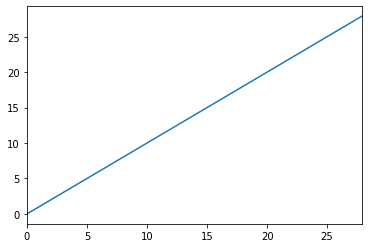

Consumption function at each aggregate market resources gridpoint (in general equilibrium):


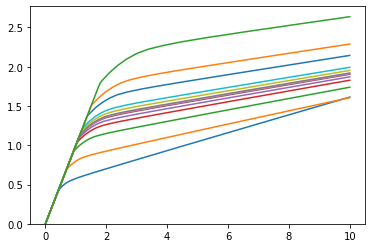

In [5]:
if solve_agg_shocks_market:
    # Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
    t_start = process_time()
    print(
        "Now solving for the equilibrium of a Cobb-Douglas economy.  This might take a few minutes..."
    )
    EconomyExample.solve()
    t_end = process_time()
    print(
        'Solving the "macroeconomic" aggregate shocks model took '
        + str(t_end - t_start)
        + " seconds."
    )

    print("Aggregate savings as a function of aggregate market resources:")
    plotFuncs(EconomyExample.AFunc, 0, 2 * EconomyExample.kSS)
    print(
        "Consumption function at each aggregate market resources gridpoint (in general equilibrium):"
    )
    AggShockExample.unpack('cFunc')
    m_grid = np.linspace(0, 10, 200)
    AggShockExample.unpack('cFunc')
    for M in AggShockExample.Mgrid.tolist():
        mMin = AggShockExample.solution[0].mNrmMin(M)
        c_at_this_M = AggShockExample.cFunc[0](m_grid + mMin, M * np.ones_like(m_grid))
        plt.plot(m_grid + mMin, c_at_this_M)
    plt.ylim(0.0, None)
    plt.show()

### Example Implementations of AggShockMarkovConsumerType

In [8]:
if solve_markov_micro or solve_markov_market or solve_krusell_smith:
    # Make a Markov aggregate shocks consumer type
    AggShockMrkvExample = AggShockMarkovConsumerType()
    AggShockMrkvExample.IncShkDstn[0] = 2 * [AggShockMrkvExample.IncShkDstn[0]]
    AggShockMrkvExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    MrkvEconomyExample = CobbDouglasMarkovEconomy(agents=[AggShockMrkvExample])
    MrkvEconomyExample.DampingFac = 0.2  # Turn down damping
    MrkvEconomyExample.makeAggShkHist()  # Simulate a history of aggregate shocks
    AggShockMrkvExample.getEconomyData(
        MrkvEconomyExample
    )  # Have the consumers inherit relevant objects from the economy

In [9]:
if solve_markov_micro:
    # Solve the microeconomic model for the Markov aggregate shocks example type (and display results)
    t_start = process_time()
    AggShockMrkvExample.solve()
    t_end = process_time()
    print(
        "Solving an aggregate shocks Markov consumer took "
        + mystr(t_end - t_start)
        + " seconds."
    )

    print(
        "Consumption function at each aggregate market \
            resources-to-labor ratio gridpoint (for each macro state):"
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockMrkvExample.unpack('cFunc')
    for i in range(2):
        for M in AggShockMrkvExample.Mgrid.tolist():
            mMin = AggShockMrkvExample.solution[0].mNrmMin[i](M)
            c_at_this_M = AggShockMrkvExample.cFunc[0][i](
                m_grid + mMin, M * np.ones_like(m_grid)
            )
            plt.plot(m_grid + mMin, c_at_this_M)
        plt.ylim(0.0, None)
        plt.show()

In [10]:
if solve_markov_market:
    # Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
    t_start = process_time()
    print("Now solving a two-state Markov economy.  This should take a few minutes...")
    MrkvEconomyExample.solve()
    t_end = process_time()
    print(
        'Solving the "macroeconomic" aggregate shocks model took '
        + str(t_end - t_start)
        + " seconds."
    )

    print(
        "Consumption function at each aggregate market \
            resources-to-labor ratio gridpoint (for each macro state):"
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockMrkvExample.unpack('cFunc')
    for i in range(2):
        for M in AggShockMrkvExample.Mgrid.tolist():
            mMin = AggShockMrkvExample.solution[0].mNrmMin[i](M)
            c_at_this_M = AggShockMrkvExample.cFunc[0][i](
                m_grid + mMin, M * np.ones_like(m_grid)
            )
            plt.plot(m_grid + mMin, c_at_this_M)
        plt.ylim(0.0, None)
        plt.show()

In [12]:
if solve_krusell_smith:
    # Make a Krusell-Smith agent type
    # NOTE: These agents aren't exactly like KS, as they don't have serially correlated unemployment
    KSexampleType = deepcopy(AggShockMrkvExample)
    KSexampleType.IncShkDstn[0] = [
        DiscreteDistribution(
            np.array([0.96, 0.04]),
            [ np.array([1.0, 1.0]), np.array([1.0 / 0.96, 0.0])]
        ),
        DiscreteDistribution(
            np.array([0.90, 0.10]),
            [np.array([1.0, 1.0]), np.array([1.0 / 0.90, 0.0])],
        )
    ]

    # Make a KS economy
    KSeconomy = deepcopy(MrkvEconomyExample)
    KSeconomy.agents = [KSexampleType]
    KSeconomy.AggShkDstn = [
        DiscreteDistribution(
            np.array([1.0]),
            [np.array([1.0]), np.array([1.05])],
        ),
        DiscreteDistribution(
            np.array([1.0]),
            [np.array([1.0]), np.array([0.95])],
        )
    ]
    KSeconomy.PermGroFacAgg = [1.0, 1.0]
    KSexampleType.getEconomyData(KSeconomy)
    KSeconomy.makeAggShkHist()

    # Solve the K-S model
    t_start = process_time()
    print(
        "Now solving a Krusell-Smith-style economy.  This should take about a minute..."
    )
    KSeconomy.solve()
    t_end = process_time()
    print("Solving the Krusell-Smith model took " + str(t_end - t_start) + " seconds.")

Now solving a Krusell-Smith-style economy.  This should take about a minute...
intercept=[-0.6136544540279432, -0.564714449492459], slope=[1.1958704882346476, 1.1792785461278616], r-sq=[0.9988205246493411, 0.9980886693480174]
intercept=[-0.42151175306905897, -0.4179282910600696], slope=[1.0846584455216068, 1.0875931006169368], r-sq=[0.9997324944505266, 0.9993135874175444]
intercept=[-0.36125200318141437, -0.35595175417340236], slope=[1.0718874825344538, 1.0715940729699065], r-sq=[0.9999983513968858, 0.9999950848251463]
intercept=[-0.37989485457273947, -0.37162769363704773], slope=[1.0790641901906513, 1.0775377304387384], r-sq=[0.9999978016051804, 0.9999931416263953]
intercept=[-0.37998317992757286, -0.371541341477626], slope=[1.0791110898828205, 1.0775162539083372], r-sq=[0.9999978056453348, 0.999992930312527]
Solving the Krusell-Smith model took 85.35971526200001 seconds.


In [13]:
if solve_poly_state:
    StateCount = 15  # Number of Markov states
    GrowthAvg = 1.01  # Average permanent income growth factor
    GrowthWidth = 0.02  # PermGroFacAgg deviates from PermGroFacAgg in this range
    Persistence = 0.90  # Probability of staying in the same Markov state
    PermGroFacAgg = np.linspace(
        GrowthAvg - GrowthWidth, GrowthAvg + GrowthWidth, num=StateCount
    )

    # Make the Markov array with chosen states and persistence
    PolyMrkvArray = np.zeros((StateCount, StateCount))
    for i in range(StateCount):
        for j in range(StateCount):
            if i == j:
                PolyMrkvArray[i, j] = Persistence
            elif (i == (j - 1)) or (i == (j + 1)):
                PolyMrkvArray[i, j] = 0.5 * (1.0 - Persistence)
    PolyMrkvArray[0, 0] += 0.5 * (1.0 - Persistence)
    PolyMrkvArray[StateCount - 1, StateCount - 1] += 0.5 * (1.0 - Persistence)

    # Make a consumer type to inhabit the economy
    PolyStateExample = AggShockMarkovConsumerType()
    PolyStateExample.MrkvArray = PolyMrkvArray
    PolyStateExample.PermGroFacAgg = PermGroFacAgg
    PolyStateExample.IncShkDstn[0] = StateCount * [PolyStateExample.IncShkDstn[0]]
    PolyStateExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    # Use verbose=False to remove printing of intercept
    PolyStateEconomy = CobbDouglasMarkovEconomy(agents=[PolyStateExample], verbose=False)
    PolyStateEconomy.MrkvArray = PolyMrkvArray
    PolyStateEconomy.PermGroFacAgg = PermGroFacAgg
    PolyStateEconomy.PermShkAggStd = StateCount * [0.006]
    PolyStateEconomy.TranShkAggStd = StateCount * [0.003]
    PolyStateEconomy.slope_prev = StateCount * [1.0]
    PolyStateEconomy.intercept_prev = StateCount * [0.0]
    PolyStateEconomy.update()
    PolyStateEconomy.makeAggShkDstn()
    PolyStateEconomy.makeAggShkHist()  # Simulate a history of aggregate shocks
    PolyStateExample.getEconomyData(
        PolyStateEconomy
    )  # Have the consumers inherit relevant objects from the economy

    # Solve the many state model
    t_start = process_time()
    print(
        "Now solving an economy with "
        + str(StateCount)
        + " Markov states.  This might take a while..."
    )
    PolyStateEconomy.solve()
    t_end = process_time()
    print(
        "Solving a model with "
        + str(StateCount)
        + " states took "
        + str(t_end - t_start)
        + " seconds."
    )